In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as et 
import matplotlib.pyplot as plt
import time
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import en_core_web_sm
import nltk
from nltk import ne_chunk, pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Alexis\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alexis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Création des dataframes

In [2]:
# ----- CREATE TRAIN DATAFRAME ----- #
l = []

xtree = et.parse("Laptop_Train.xml")
xroot = xtree.getroot()
for sentence in xroot.findall('sentence'):
    idi = sentence.get('id')
    text = sentence.find('text').text

    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
        
df_train = pd.DataFrame(l)
df_train.head(5)

,term,polarity,from,to,id,text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...
2,service center,negative,27,41,1316,The tech guy then said the service center does...
3,"""sales"" team",negative,109,121,1316,The tech guy then said the service center does...
4,tech guy,neutral,4,12,1316,The tech guy then said the service center does...


In [3]:
# ----- CREATE Test GOLD DATAFRAME ----- #
l = []

xtreeGoldTest = et.parse("Laptop_Test_Gold.xml")
xroot = xtreeGoldTest.getroot()
for sentence in xroot.findall('sentence'):
    idi = sentence.get('id')
    text = sentence.find('text').text
    
    #print(idi, text)
    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
df_testGold = pd.DataFrame(l)
df_testGold.head(5)

,term,polarity,from,to,id,text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!
2,build quality,negative,9,22,353,"From the build quality to the performance, eve..."
3,performance,negative,30,41,353,"From the build quality to the performance, eve..."
4,costing,positive,30,37,655,It was truly a great computer costing less tha...


## Tokenize et Pos Tag

In [4]:
# ----- TOKENIZE & POS TAG du TRAIN ----- #
nlp = en_core_web_sm.load()

df_train['token_text'] = df_train.apply(lambda row: nlp(row["text"]), axis=1)

df_train

,term,polarity,from,to,id,text,token_text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...,"(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...,"(I, charge, it, at, night, and, skip, taking, ..."
2,service center,negative,27,41,1316,The tech guy then said the service center does...,"(The, tech, guy, then, said, the, service, cen..."
3,"""sales"" team",negative,109,121,1316,The tech guy then said the service center does...,"(The, tech, guy, then, said, the, service, cen..."
4,tech guy,neutral,4,12,1316,The tech guy then said the service center does...,"(The, tech, guy, then, said, the, service, cen..."
...,...,...,...,...,...,...,...
2353,Windows Server Enterprise 2003,neutral,104,134,2272,We also use Paralles so we can run virtual mac...,"(We, also, use, Paralles, so, we, can, run, vi..."
2354,Windows Server 2008 Enterprise,neutral,140,170,2272,We also use Paralles so we can run virtual mac...,"(We, also, use, Paralles, so, we, can, run, vi..."
2355,repair,conflict,24,30,848,"How Toshiba handles the repair seems to vary, ...","(How, Toshiba, handles, the, repair, seems, to..."
2356,repair,positive,130,136,848,"How Toshiba handles the repair seems to vary, ...","(How, Toshiba, handles, the, repair, seems, to..."


In [5]:
# on vérifie que les posTag ont bien été conservés
df_train.token_text[0]
[X.pos_ for X in  df_train.token_text[0]]

['PRON',
 'VERB',
 'PRON',
 'ADP',
 'NOUN',
 'CCONJ',
 'VERB',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'PRON',
 'SCONJ',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 'NOUN',
 'PUNCT']

In [6]:
# ----- TOKENIZE & POS TAG TEST GOLD ----- #
df_testGold['token_text'] = df_testGold.apply(lambda row: nlp(row["text"]), axis=1)

df_testGold

,term,polarity,from,to,id,text,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,"(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,"(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...","(From, the, build, quality, to, the, performan..."
3,performance,negative,30,41,353,"From the build quality to the performance, eve...","(From, the, build, quality, to, the, performan..."
4,costing,positive,30,37,655,It was truly a great computer costing less tha...,"(It, was, truly, a, great, computer, costing, ..."
5,Boots up,positive,0,8,2443,Boots up fast and runs great!,"(Boots, up, fast, and, runs, great, !)"
6,runs,positive,18,22,2443,Boots up fast and runs great!,"(Boots, up, fast, and, runs, great, !)"
7,tech support,neutral,5,17,764,"Call tech support, standard email the form and...","(Call, tech, support, ,, standard, email, the,..."
8,service,positive,4,11,1479,The service I received from Toshiba went above...,"(The, service, I, received, from, Toshiba, wen..."
9,internet speed,positive,41,55,2937,I would recommend it just because of the inter...,"(I, would, recommend, it, just, because, of, t..."


## Partie Sentiments
### Assignation de la polarité de chaque mot & Ajout des polarités dans les dataframes

In [7]:
#### Assigner la polarité de chaque mot et les ajouter dans les dataframes

df_train.insert(6,'Score_by_word',"")
df_testGold.insert(6,'Score_by_word',"")

df_train.insert(7,'Sentiword',"")
df_testGold.insert(7,'Sentiword',"")

df_testGold.head(4)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,,,"(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,,,"(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...",,,"(From, the, build, quality, to, the, performan..."
3,performance,negative,30,41,353,"From the build quality to the performance, eve...",,,"(From, the, build, quality, to, the, performan..."


In [9]:
def penn_to_wn(tag):
  """
  Convertion des tags en simple WORDNET TAGS
  """
  if tag.startswith('J'):
    return wn.ADJ
  elif tag.startswith('N'):
    return wn.NOUN
  elif tag.startswith('R'):
    return wn.ADV
  elif tag.startswith('V'):
    return wn.VERB
  return None

lemmatizer = WordNetLemmatizer()

# CHARGEMENT DES SENTIMENTS DETECTES
def get_sentiment(word,tag):
  """
  Return une liste de score positif negatif ou neutre et return une liste vide si le mot ne renvoie rien depuis senti wordnet.
  """
  wn_tag = penn_to_wn(tag)
  if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
    return []

  lemma = lemmatizer.lemmatize(word, pos=wn_tag)
  if not lemma:
    return []

  synsets = wn.synsets(word, pos=wn_tag)
  if not synsets:
    return []

  # Prend le premier sens du mot c'est à dire le sens le plus commun
  synset = synsets[0]
  swn_synset = swn.senti_synset(synset.name())

  return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [10]:
# On remplit nos colonnes vides
# ---------- TRAIN DATAFRAME ---------------- #
ps = PorterStemmer()
i=0
for token in df_train.text :
    words_data= nltk.word_tokenize(str(token))
    tokens_without_sw = [word for word in words_data if not word in stopwords.words()]


    pos_val = nltk.pos_tag(tokens_without_sw)


    scores = []
    words_sentence = []

    for (x,y) in pos_val :
        scores.append(get_sentiment(x,y))
        words_sentence.append(x)

    df_train['Sentiword'][i] = words_sentence
    df_train['Score_by_word'][i] = scores
    i+=1

df_train.head(10)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
2,service center,negative,27,41,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."
3,"""sales"" team",negative,109,121,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."
4,tech guy,neutral,4,12,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."
5,quality,positive,14,21,2005,"it is of high quality, has a killer GUI, is ex...","[[0.125, 0.25, 0.625], [0.375, 0.0, 0.625], []...","[high, quality, ,, killer, GUI, ,, extremely, ...","(it, is, of, high, quality, ,, has, a, killer,..."
6,GUI,positive,36,39,2005,"it is of high quality, has a killer GUI, is ex...","[[0.125, 0.25, 0.625], [0.375, 0.0, 0.625], []...","[high, quality, ,, killer, GUI, ,, extremely, ...","(it, is, of, high, quality, ,, has, a, killer,..."
7,applications,positive,118,130,2005,"it is of high quality, has a killer GUI, is ex...","[[0.125, 0.25, 0.625], [0.375, 0.0, 0.625], []...","[high, quality, ,, killer, GUI, ,, extremely, ...","(it, is, of, high, quality, ,, has, a, killer,..."
8,use,positive,143,146,2005,"it is of high quality, has a killer GUI, is ex...","[[0.125, 0.25, 0.625], [0.375, 0.0, 0.625], []...","[high, quality, ,, killer, GUI, ,, extremely, ...","(it, is, of, high, quality, ,, has, a, killer,..."
9,start up,positive,8,16,2789,Easy to start up and does not overheat as much...,"[[0.625, 0.25, 0.125], [], [], [0.0, 0.0, 1.0]...","[Easy, start, overheat, much, laptops, .]","(Easy, to, start, up, and, does, not, overheat..."


In [11]:
# On remplit nos  colonnes vides
# ---------- TEST DATAFRAME ---------------- #
ps = PorterStemmer()
i=0
for token in df_testGold.text :
    words_data= nltk.word_tokenize(str(token))
    tokens_without_sw = [word for word in words_data if not word in stopwords.words()]


    pos_val = nltk.pos_tag(tokens_without_sw)


    scores = []
    words_sentence = []

    for (x,y) in pos_val :
        scores.append(get_sentiment(x,y))
        words_sentence.append(x)

    df_testGold['Sentiword'][i] = words_sentence
    df_testGold['Score_by_word'][i] = scores
    i+=1

df_testGold.head(10)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]","[I, liked, aluminum, body, .]","(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]","[Lightweight, screen, beautiful, !]","(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...","[From, build, quality, performance, ,, everyth...","(From, the, build, quality, to, the, performan..."
3,performance,negative,30,41,353,"From the build quality to the performance, eve...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...","[From, build, quality, performance, ,, everyth...","(From, the, build, quality, to, the, performan..."
4,costing,positive,30,37,655,It was truly a great computer costing less tha...,"[[], [0.625, 0.0, 0.375], [0.0, 0.0, 1.0], [0....","[It, truly, great, computer, costing, less, th...","(It, was, truly, a, great, computer, costing, ..."
5,Boots up,positive,0,8,2443,Boots up fast and runs great!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0.0, 0...","[Boots, fast, runs, great, !]","(Boots, up, fast, and, runs, great, !)"
6,runs,positive,18,22,2443,Boots up fast and runs great!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0.0, 0...","[Boots, fast, runs, great, !]","(Boots, up, fast, and, runs, great, !)"
7,tech support,neutral,5,17,764,"Call tech support, standard email the form and...","[[], [], [0.0, 0.0, 1.0], [], [0.375, 0.375, 0...","[Call, tech, support, ,, standard, email, form...","(Call, tech, support, ,, standard, email, the,..."
8,service,positive,4,11,1479,The service I received from Toshiba went above...,"[[], [0.0, 0.0, 1.0], [], [], [], [], [], [0.0...","[The, service, I, received, Toshiba, went, bey...","(The, service, I, received, from, Toshiba, wen..."
9,internet speed,positive,41,55,2937,I would recommend it just because of the inter...,"[[], [], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0],...","[I, would, recommend, internet, speed, probabl...","(I, would, recommend, it, just, because, of, t..."


In [12]:
# On ajoute une colonne avec seulement les POStag
# (il est plus facile de retirer des colonnes que d'en ajouter plus tard)

df_train.insert(7,'PosTag',"")
df_testGold.insert(7,'PosTag',"")

df_testGold.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]",,"[I, liked, aluminum, body, .]","(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]",,"[Lightweight, screen, beautiful, !]","(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...",,"[From, build, quality, performance, ,, everyth...","(From, the, build, quality, to, the, performan..."


In [13]:
# On remplit 
for i in range(len(df_train.PosTag)):
    df_train['PosTag'][i] = [(X.pos_) for X in  df_train.token_text[i]]

for i in range(len(df_testGold.PosTag)):
    df_testGold['PosTag'][i] = [(X.pos_) for X in  df_testGold.token_text[i]]



In [14]:
df_train.head(3) 

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, PRON, ADP, NOUN, CCONJ, VERB, VER...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, PRON, ADP, NOUN, CCONJ, VERB, VER...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
2,service center,negative,27,41,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[DET, NOUN, NOUN, ADV, VERB, DET, NOUN, NOUN, ...","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."


In [15]:
df_testGold.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]","[PRON, VERB, DET, NOUN, NOUN, PUNCT]","[I, liked, aluminum, body, .]","(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]","[PROPN, CCONJ, DET, NOUN, AUX, ADJ, PUNCT]","[Lightweight, screen, beautiful, !]","(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...","[ADP, DET, NOUN, NOUN, ADP, DET, NOUN, PUNCT, ...","[From, build, quality, performance, ,, everyth...","(From, the, build, quality, to, the, performan..."


### Tri dans les dataframes

In [16]:
# ---------- TRAIN DATAFRAME ---------------- #
DF_train = df_train[['term','text','PosTag','Sentiword','Score_by_word','polarity','token_text']]
DF_train.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,cord,I charge it at night and skip taking the cord ...,"[PRON, VERB, PRON, ADP, NOUN, CCONJ, VERB, VER...","[I, charge, night, skip, taking, cord, good, b...","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...",neutral,"(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,I charge it at night and skip taking the cord ...,"[PRON, VERB, PRON, ADP, NOUN, CCONJ, VERB, VER...","[I, charge, night, skip, taking, cord, good, b...","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...",positive,"(I, charge, it, at, night, and, skip, taking, ..."
2,service center,The tech guy then said the service center does...,"[DET, NOUN, NOUN, ADV, VERB, DET, NOUN, NOUN, ...","[The, tech, guy, said, service, center, 1-to-1...","[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....",negative,"(The, tech, guy, then, said, the, service, cen..."


In [17]:
# ---------- TEST DATAFRAME ---------------- #
DF_test = df_testGold[['term','text','PosTag','Sentiword','Score_by_word','polarity','token_text']]
DF_test.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,aluminum body,I liked the aluminum body.,"[PRON, VERB, DET, NOUN, NOUN, PUNCT]","[I, liked, aluminum, body, .]","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]",positive,"(I, liked, the, aluminum, body, .)"
1,screen,Lightweight and the screen is beautiful!,"[PROPN, CCONJ, DET, NOUN, AUX, ADJ, PUNCT]","[Lightweight, screen, beautiful, !]","[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]",positive,"(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,"From the build quality to the performance, eve...","[ADP, DET, NOUN, NOUN, ADP, DET, NOUN, PUNCT, ...","[From, build, quality, performance, ,, everyth...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...",negative,"(From, the, build, quality, to, the, performan..."


In [18]:
# sauvegarder en Dataframe grace à .pkl
df_train.to_pickle('df_train_PANDAS_DATAFRAME.pkl')  
df_testGold.to_pickle('df_test_PANDAS_DATAFRAME.pkl')

#Pour recharger les dataframe : 
df_train = pd.read_pickle('df_train_PANDAS_DATAFRAME.pkl')
df_testGold = pd.read_pickle('df_test_PANDAS_DATAFRAME.pkl')

df_train.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, PRON, ADP, NOUN, CCONJ, VERB, VER...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, PRON, ADP, NOUN, CCONJ, VERB, VER...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
2,service center,negative,27,41,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[DET, NOUN, NOUN, ADV, VERB, DET, NOUN, NOUN, ...","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."


## Visualisation

### Repartition de la polarite

(array([[460.,   0.,   0., 987.,   0.,   0., 866.,   0.,   0.,  45.],
        [  4.,   0.,   0.,  29.,   0.,   0.,  16.,   0.,   0.,   0.]]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 BarContainer objects>)

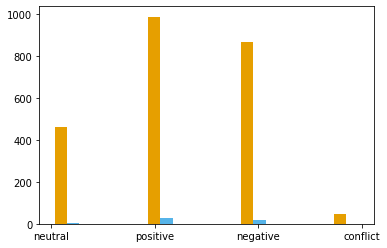

In [19]:
x1 = DF_train['polarity']
x2 = DF_test['polarity']

# on assigne une couleur unique (plus lisible sur le graphique)
colors = ['#E69F00', '#56B4E9']
names = ['TRAIN', 'TEST']
         

plt.hist([x1, x2],color = colors, label=names)

In [20]:
# NOMBRES
## TRAIN
posTrain=len(DF_train[DF_train['polarity'] == 'positive' ].index)
negTrain=len(DF_train[DF_train['polarity'] == 'negative' ].index)
neuTrain=len(DF_train[DF_train['polarity'] == 'neutral' ].index)
confTrain=len(DF_train[DF_train['polarity'] == 'conflict' ].index)

## TEST
posTest=len(DF_test[DF_test['polarity'] == 'positive' ].index)
negTest=len(DF_test[DF_test['polarity'] == 'negative' ].index)
neuTest=len(DF_test[DF_test['polarity'] == 'neutral' ].index)
confTest=len(DF_test[DF_test['polarity'] == 'conflict' ].index)

print("### TRAIN ###")
print("Nombre de positif : ",posTrain,", Nombre de negatif : ",negTrain,", Nombre de neutre : ",neuTrain,", Nombre de conflits : ",confTrain)
print("### TEST ###")
print("Nombre de positif : ",posTest,", Nombre de negatif : ",negTest,", Nombre de neutre : ",neuTest,", Nombre de conflits : ",confTest)

# TAUX
## TRAIN
pos_train=len(DF_train[DF_train['polarity'] == 'positive' ].index)/len(DF_train)*100
neg_train=len(DF_train[DF_train['polarity'] == 'negative' ].index)/len(DF_train)*100
neu_train=len(DF_train[DF_train['polarity'] == 'neutral' ].index)/len(DF_train)*100
conf_train=len(DF_train[DF_train['polarity'] == 'conflict' ].index)/len(DF_train)*100

## TEST
pos_test=len(DF_test[DF_test['polarity'] == 'positive' ].index)/len(DF_test)*100
neg_test=len(DF_test[DF_test['polarity'] == 'negative' ].index)/len(DF_test)*100
neu_test=len(DF_test[DF_test['polarity'] == 'neutral' ].index)/len(DF_test)*100
conf_test=len(DF_test[DF_test['polarity'] == 'conflict' ].index)/len(DF_test)*100

print("### TRAIN ###")
print("Positive : ",pos_train," %, Negative : ",neg_train," %, Neutral : ",neu_train," %, Conflicts : ",conf_train, " %")
print("### TEST ###")
print("Positive : ",pos_test," %, Negative : ",neg_test," %, Neutral : ",neu_test," %, Conflicts : ",conf_test, " %")

### TRAIN ###
Nombre de positif :  987 , Nombre de negatif :  866 , Nombre de neutre :  460 , Nombre de conflits :  45
### TEST ###
Nombre de positif :  29 , Nombre de negatif :  16 , Nombre de neutre :  4 , Nombre de conflits :  0
### TRAIN ###
Positive :  41.85750636132315  %, Negative :  36.72603901611535  %, Neutral :  19.508057675996607  %, Conflicts :  1.9083969465648856  %
### TEST ###
Positive :  59.183673469387756  %, Negative :  32.6530612244898  %, Neutral :  8.16326530612245  %, Conflicts :  0.0  %


Text(0.5, 1.0, 'Répartition en % des données en fonctions de leurs polarités ')

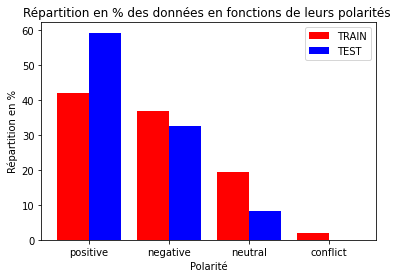

In [21]:
# Affichage au format Histogramme
barWidth = 0.4
train = [pos_train, neg_train, neu_train, conf_train]
test = [pos_test, neg_test, neu_test, conf_test]
r1 = range(len(train))
r2 = [x + barWidth for x in r1]

plotTrain= plt.bar(r1, train, width = barWidth, color = ['red' for i in train])
plotTest= plt.bar(r2, test, width = barWidth, color = ['blue' for i in train])
plt.xticks([r + barWidth / 2 for r in range(len(train))], ['positive', 'negative', 'neutral','conflict'])
plt.legend([plotTrain, plotTest], ['TRAIN', 'TEST'])
plt.xlabel("Polarité")
plt.ylabel("Répartition en %")
plt.title("Répartition en % des données en fonctions de leurs polarités ")

In [22]:
# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_train[DF_train['polarity'] == 'conflict' ].index
# on retire les lignes concernées
DF_train.drop(indexNames , inplace=True)

# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_test[DF_test['polarity'] == 'conflict' ].index
# on retire les lignes concernées
DF_test.drop(indexNames , inplace=True)

F:\COURS\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_train[DF_train['polarity'] == 'conflict' ].index

# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_test[DF_test['polarity'] == 'conflict' ].index

In [24]:
# Save 
DF_train.to_pickle('DF_train_PANDAS_DATAFRAME.pkl')  
DF_test.to_pickle('DF_test_PANDAS_DATAFRAME.pkl')  

#Pour recharger les dataframe : 
DF_train = pd.read_pickle('DF_train_PANDAS_DATAFRAME.pkl')
DF_test = pd.read_pickle('DF_test_PANDAS_DATAFRAME.pkl')

In [25]:
DF_train.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,cord,I charge it at night and skip taking the cord ...,"[PRON, VERB, PRON, ADP, NOUN, CCONJ, VERB, VER...","[I, charge, night, skip, taking, cord, good, b...","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...",neutral,"(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,I charge it at night and skip taking the cord ...,"[PRON, VERB, PRON, ADP, NOUN, CCONJ, VERB, VER...","[I, charge, night, skip, taking, cord, good, b...","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...",positive,"(I, charge, it, at, night, and, skip, taking, ..."
2,service center,The tech guy then said the service center does...,"[DET, NOUN, NOUN, ADV, VERB, DET, NOUN, NOUN, ...","[The, tech, guy, said, service, center, 1-to-1...","[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....",negative,"(The, tech, guy, then, said, the, service, cen..."


In [26]:
DF_test.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,aluminum body,I liked the aluminum body.,"[PRON, VERB, DET, NOUN, NOUN, PUNCT]","[I, liked, aluminum, body, .]","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]",positive,"(I, liked, the, aluminum, body, .)"
1,screen,Lightweight and the screen is beautiful!,"[PROPN, CCONJ, DET, NOUN, AUX, ADJ, PUNCT]","[Lightweight, screen, beautiful, !]","[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]",positive,"(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,"From the build quality to the performance, eve...","[ADP, DET, NOUN, NOUN, ADP, DET, NOUN, PUNCT, ...","[From, build, quality, performance, ,, everyth...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...",negative,"(From, the, build, quality, to, the, performan..."


### Conversion des dataframes en listes

In [27]:
print("DataFrame after reset_index:")
DF_train.reset_index(inplace=True, drop=False)

DataFrame after reset_index:


In [28]:
# TRAIN DATASET
df_train = DF_train

list_train = []
label_train = []
print(df_train)
for i in range(len(df_train)):
    pos_tag = [X.pos_ for X in  df_train.token_text[i]]
    pos_tag_text = " ".join(pos_tag)
    senti_word = " ".join(df_train.Sentiword[i])
    score_by_word = ",".join(str(v) for v in df_train.Score_by_word[i])
    
    list_train.append(
        (df_train.term[i],
        df_train.text[i],
        pos_tag_text,
        senti_word,
        score_by_word,
        ))
    label_train.append(df_train.polarity[i])

list_train

Laptop_Train = np.array(list_train)
print(Laptop_Train)


      index                            term  \
0         0                            cord   
1         1                    battery life   
2         2                  service center   
3         3                    "sales" team   
4         4                        tech guy   
...     ...                             ...   
2308   2352          Windows 7 Home Premium   
2309   2353  Windows Server Enterprise 2003   
2310   2354  Windows Server 2008 Enterprise   
2311   2356                          repair   
2312   2357                operating system   

                                                   text  \
0     I charge it at night and skip taking the cord ...   
1     I charge it at night and skip taking the cord ...   
2     The tech guy then said the service center does...   
3     The tech guy then said the service center does...   
4     The tech guy then said the service center does...   
...                                                 ...   
2308  We also use Para

In [29]:
# TEST DATASET
df_test = DF_test

list_test = []
label_test = []

for i in range(len(df_test)):
    pos_tag = [X.pos_ for X in  df_test.token_text[i]]
    pos_tag_text = " ".join(pos_tag)
    senti_word = " ".join(df_test.Sentiword[i])
    score_by_word = ",".join(str(v) for v in df_test.Score_by_word[i])
    
    list_test.append(
        (df_test.term[i],
        df_test.text[i],
        pos_tag_text,
        senti_word,
        score_by_word,
        ))
    label_test.append(df_test.polarity[i])


import numpy as np
Laptop_Test = np.array(list_test)
print(Laptop_Test)


[['aluminum body' 'I liked the aluminum body.'
  'PRON VERB DET NOUN NOUN PUNCT' 'I liked aluminum body .'
  '[],[],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[]']
 ['screen' 'Lightweight and the screen is beautiful!'
  'PROPN CCONJ DET NOUN AUX ADJ PUNCT' 'Lightweight screen beautiful !'
  '[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[],[]']
 ['build quality'
  'From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple.'
  'ADP DET NOUN NOUN ADP DET NOUN PUNCT PRON ADP PRON AUX AUX ADJ NOUN NOUN ADP PRON PRON AUX AUX VERB ADP PROPN PUNCT'
  'From build quality performance , everything sub-par I would expected Apple .'
  '[],[],[0.375, 0.0, 0.625],[0.125, 0.0, 0.875],[],[],[],[],[],[],[0.0, 0.0, 1.0],[]']
 ['performance'
  'From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple.'
  'ADP DET NOUN NOUN ADP DET NOUN PUNCT PRON ADP PRON AUX AUX ADJ NOUN NOUN ADP PRON PRON AUX AUX V

## Vectorisation — TF/IDF

### Premier test avec seulement la colonne text comme variable explicative

In [30]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(DF_train['text'])
test_vectors = vectorizer.transform(DF_test['text'])

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, DF_train['polarity'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(DF_test['polarity'], prediction_linear, output_dict=True)


print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 0.476909s; Prediction time: 0.008006s
positive:  {'precision': 0.8620689655172413, 'recall': 0.8620689655172413, 'f1-score': 0.8620689655172413, 'support': 29}
negative:  {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 16}
neutral:  {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 4}


Là, notre modèle prédit positif ou négatif sans savoir le term dont il s'agit. Il n'a que les phrases pour prédire. Donc ce n'est pas ce que nosu cherchons à observer.

### Normalisation des dimensions de nos listes.

In [42]:
### TEST ###
L = len(Laptop_Test)
X_test = []
y_test = []
for i in range(0,L):
    X_test.append(Laptop_Test[i][0] + " " + Laptop_Test[i][1] + " " + Laptop_Test[i][2] + " " + Laptop_Test[i][3]+ " " + Laptop_Test[i][4])
    y_test.append(label_test[i])

In [41]:
### TRAIN ###

L = len(Laptop_Train)
X_train = []
y_train = []
for i in range(0,L):
    X_train.append(Laptop_Train[i][0] + " " + Laptop_Train[i][1] + " " + Laptop_Train[i][2] + " " + Laptop_Train[i][3]+ " " + Laptop_Train[i][4])
    y_train.append(label_train[i]) 

### Vectorisation avec TfidfTransformer

In [33]:
# Creation des vecteurs
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

X_train_tf = tf_transformer.transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_counts)

print(X_train_counts.shape)
print(X_train_tf.shape)

print(X_test_counts.shape)
print(X_test_tf.shape)

(2313, 3079)
(2313, 3079)
(49, 3079)
(49, 3079)


In [36]:
# Test avec kernel=rbf
classifier_linear = svm.SVC(kernel='rbf')
t0 = time.time()
classifier_linear.fit(X_train_tf, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test_tf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, output_dict=True)

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 0.931799s; Prediction time: 0.016514s
positive:  {'precision': 0.8666666666666667, 'recall': 0.896551724137931, 'f1-score': 0.8813559322033899, 'support': 29}
negative:  {'precision': 0.7647058823529411, 'recall': 0.8125, 'f1-score': 0.787878787878788, 'support': 16}
neutral:  {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 4}


In [37]:
# Test avec kernel=poly
classifier_linear = svm.SVC(kernel='poly')
t0 = time.time()
classifier_linear.fit(X_train_tf, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test_tf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, output_dict=True)

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 1.012870s; Prediction time: 0.015513s
positive:  {'precision': 0.90625, 'recall': 1.0, 'f1-score': 0.9508196721311475, 'support': 29}
negative:  {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 16}
neutral:  {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}


- F1 Score positif --> 0.95 --> 95 % (supérieur à rbf 0.88 --> 88 % )
- F1 Score negatif --> 0.93 --> 93 % (supérieur à rbf 0.78 --> 78 %)
- F1 Score neutre --> 0.85 --> 85 % (supérieur à rbf 0.66 --> 66 %)

D'après les résultats obtenu, le noyau Polynomial semble donner de meilleurs résultats que le kernel Radial basis function (rbf) ou linéaire, notamment pour les positifs et les neutres. On garde alors la typologie avec le kernel POLY.